# 🧠 Descrição do notebook
Este notebook demonstra como utilizar o método FairShap para reponderação de dados com foco em fairness, aplicado no dataset COMPAS

# Install

In [2]:
# 📦 Instalação de dependências (em múltiplas linhas para melhor leitura)
!pip install \
    numpy \
    pandas \
    matplotlib \
    seaborn \
    shap \
    scikit-learn \
    tqdm \
    aif360 \




# Carregar funções auxiliares

In [15]:
%run func_aux.ipynb

# Carregando Dataset

In [160]:
from aif360.sklearn.datasets import fetch_compas
import pandas as pd
# 🚩 Carrega o dataset
dataset = fetch_compas()
print(type(dataset))
# Transforma X em DataFrame para acessar pelo nome da coluna
X = pd.DataFrame(dataset.X)
y = dataset.y

print(X.columns)
print(y.name)

<class 'aif360.sklearn.datasets.utils.Dataset'>
Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc'],
      dtype='object')
two_year_recid


# Tratamendo dos dados

 🔧 Plano de pré-processamento dos dados (COMPAS)

Este notebook utiliza um pipeline de pré-processamento projetado para tratar as variáveis não numéricas do dataset COMPAS de forma clara, interpretável e alinhada às boas práticas de fairness.

🔥 Decisões tomadas:

- **`age_cat` → DROP**  
Variável categórica redundante com `age` (numérica), portanto removida.

- **`c_charge_desc` → DROP**  
Descrição textual livre da acusação. Exigiria processamento de linguagem natural (NLP) para ser útil, e não é essencial para o escopo atual.

- **`sex`, `c_charge_degree`,`race`  → One-hot encoding (sem `drop_first`)**  

 🔧 Mapeamento dos Labels

Os labels estão como strings (`'Survived'` e `'Recidivated'`).  
Mapeamos `'Survived' → 0` (não reincidente) e `'Recidivated' → 1` (reincidente).  
Isso é necessário, pois modelos e o FairShap exigem labels numéricos.  

 ✔️ Resultado final das features:

- Colunas numéricas:  
`age`, `juv_fel_count`, `juv_misd_count`, `juv_other_count`, `priors_count`

- Colunas categóricas transformadas:  
`Female`, `Male`, `Felony`, `Misdemeanor`, `Caucasian`, `AfricanAmerican`, etc

 🏗️ Justificativa geral:
Este tratamento mantém a interpretação intuitiva das features, evita ambiguidades e é diretamente aplicável tanto em modelos de machine learning quanto na análise de fairness com FairShap.


In [161]:
import numpy as np
# =============================
# 🔥 Tratamento dos categóricos
# =============================

# ✔️ 1. DROP das colunas que não vamos usar
X = X.drop(columns=['age_cat', 'c_charge_desc'])

# ✔️ 2. Mapear 'F' e 'M' de c_charge_degree
X['c_charge_degree'] = X['c_charge_degree'].map({'F': 'Felony', 'M': 'Misdemeanor'})

# ✔️ 3. Criar dummies para 'sex' e 'c_charge_degree' e 'race' (sem drop_first)
X = pd.get_dummies(X, columns=['sex', 'c_charge_degree','race'], drop_first=False)


#para utilizar na avaliação depois
race_columns = [col for col in X.columns if col.startswith('race_')]
race_columns = [col.replace('race_', '') for col in race_columns]


# ✔️ Renomeando colunas para nomes mais simples e diretos
X.columns = [
    name.replace('sex_', '')
        .replace('c_charge_degree_', '')
        .replace('race_', '')
    if any(prefix in name for prefix in ['sex_', 'c_charge_degree_', 'race_'])
    else name
    for name in X.columns
]


# Mapeamento dos labels para 0 e 1
label_map = {'Survived': 0, 'Recidivated': 1}

y = np.array([label_map[val] for val in dataset.y])


print("✔️ Features finais:", X.columns.tolist())

✔️ Features finais: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'Male', 'Female', 'Misdemeanor', 'Felony', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']


### 🔄 Normalização — Por que aplicamos no pipeline?
A normalização é essencial porque o FairShap utiliza KNN, que é sensível à escala das variáveis. Sem normalizar, variáveis com magnitudes maiores dominariam o cálculo de distâncias, distorcendo os Shapley Values e prejudicando o resultado.

Além disso, modelos como Redes Neurais (MLP) também exigem normalização, pois dados em escalas muito diferentes geram gradientes mal condicionados, afetando a estabilidade e a velocidade de convergência do treinamento.

Já modelos como Gradient Boosting (GBC) e árvores de decisão não precisam de normalização, pois são baseados em splits. Porém, mantemos a normalização no pipeline para garantir consistência, já que ela é indispensável para o FairShap e para MLP.

In [162]:
from sklearn.preprocessing import StandardScaler
import copy
# ========================================
# 🧼 Normalização dos dados (exceto y e A)
# ========================================


# ✔️ Detectar automaticamente variáveis binárias e contínuas
binary_cols = [
    col for col in X.columns
    if set(X[col].unique()).issubset({0, 1})
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

print("✔️ Variáveis binárias:", binary_cols)
print("✔️ Variáveis contínuas:", continuous_cols)

# ✔️ Normalizar apenas as variáveis contínuas
scaler = StandardScaler()
X_continuous = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols
)

# ✔️ Manter as binárias sem alteração
X_binarias = X[binary_cols].reset_index(drop=True)

# ✔️ Concatenar
X_scaled = pd.concat([X_continuous, X_binarias], axis=1)
X_scaled.columns = X.columns

copia_scaled = copy.deepcopy(X_scaled)

print("✔️ Dados preparados com sucesso!")
print("Shape de X_scaled:", X_scaled.shape)
print(X_scaled.columns)

✔️ Variáveis binárias: ['Male', 'Female', 'Misdemeanor', 'Felony', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
✔️ Variáveis contínuas: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
✔️ Dados preparados com sucesso!
Shape de X_scaled: (6167, 15)
Index(['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'Male', 'Female', 'Misdemeanor', 'Felony',
       'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American',
       'Other'],
      dtype='object')


### 🔄 Sem Normalização — para melhor explicabilidade

In [164]:
import copy
copia = copy.deepcopy(X)

# Sumário do Dataset

In [149]:
#carregando funções auxiliares
%run func_aux.ipynb

aux = X
aux['Reincidente'] = y
summarize_dataset(aux)
dist_racial(aux,race_columns)


📦 Tamanho do dataset:
- Linhas: 6167
- Colunas: 16

📄 Primeiras 5 linhas:


age  juv_fel_count  juv_misd_count  juv_other_count  \
sex  race                                                                    
Male Other              69              0               0                0   
     African-American   34              0               0                0   
     African-American   24              0               0                1   
     Other              44              0               0                0   
     Caucasian          41              0               0                0   

                       priors_count  Male  Female  Misdemeanor  Felony  \
sex  race                                                                
Male Other                        0  True   False        False    True   
     African-American             0  True   False        False    True   
     African-American             4  True   False        False    True   
     Other                        0  True   False         True   False   
     Caucasian                   14  True   False        False    True   

                       African-American  Asian  Caucasian  Hispanic  \
sex  race                                                             
Male Other                        False  False      False     False   
     African-American              True  False      False     False   
     African-American              True  False      False     False   
     Other                        False  False      False     False   
     Caucasian                    False  False       True     False   

                       Native American  Other  Reincidente  
sex  race                                                   
Male Other                       False   True            0  
     African-American            False  False            1  
     African-American            False  False            1  
     Other                       False   True            0  
     Caucasian                   False  False            1


🔢 Informações básicas:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6167 entries, ('Male', 'Other') to ('Female', 'Hispanic')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   age               6167 non-null   int64
 1   juv_fel_count     6167 non-null   int64
 2   juv_misd_count    6167 non-null   int64
 3   juv_other_count   6167 non-null   int64
 4   priors_count      6167 non-null   int64
 5   Male              6167 non-null   bool 
 6   Female            6167 non-null   bool 
 7   Misdemeanor       6167 non-null   bool 
 8   Felony            6167 non-null   bool 
 9   African-American  6167 non-null   bool 
 10  Asian             6167 non-null   bool 
 11  Caucasian         6167 non-null   bool 
 12  Hispanic          6167 non-null   bool 
 13  Native American   6167 non-null   bool 
 14  Other             6167 non-null   bool 
 15  Reincidente       6167 non-null   int64
dtypes: bool(10), int64(6

None


📈 Estatísticas descritivas:


count       mean        std   min   25%   50%   75%   max
age              6167.0  34.531863  11.726167  18.0  25.0  31.0  42.0  96.0
juv_fel_count    6167.0   0.059186   0.463630   0.0   0.0   0.0   0.0  20.0
juv_misd_count   6167.0   0.091292   0.498067   0.0   0.0   0.0   0.0  13.0
juv_other_count  6167.0   0.110751   0.470911   0.0   0.0   0.0   0.0   9.0
priors_count     6167.0   3.247446   4.745320   0.0   0.0   1.0   4.0  38.0
Reincidente      6167.0   0.455489   0.498055   0.0   0.0   0.0   1.0   1.0


🧾 Colunas categóricas/dummies:
- juv_fel_count: [ 0  2  1  8  3  4 20  6  5 10] (n=10)
- juv_misd_count: [ 0  1  6 12  2  4  3  8  5 13] (n=10)
- juv_other_count: [0 1 3 4 2 9 5 6 7] (n=9)
- Male: [ True False] (n=2)
- Female: [False  True] (n=2)
- Misdemeanor: [False  True] (n=2)
- Felony: [ True False] (n=2)
- African-American: [False  True] (n=2)
- Asian: [False  True] (n=2)
- Caucasian: [False  True] (n=2)
- Hispanic: [False  True] (n=2)
- Native American: [False  True] (n=2)
- Other: [ True False] (n=2)
- Reincidente: [0 1] (n=2)

📊 Correlação entre variáveis numéricas:



⚠️ Colunas com valores nulos:
✅ Nenhum valor nulo encontrado.

📊 Raça: African-American
Total de indivíduos: 3173



📊 Raça: Asian
Total de indivíduos: 31



📊 Raça: Caucasian
Total de indivíduos: 2100



📊 Raça: Hispanic
Total de indivíduos: 509



📊 Raça: Native American
Total de indivíduos: 11



📊 Raça: Other
Total de indivíduos: 343


# Models - Aware

## modelo_nulo

In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from collections import Counter

class DummyMostFrequentClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        # Descobre a classe mais frequente
        counts = Counter(y)
        self.classe_mais_frequente_ = counts.most_common(1)[0][0]
        return self

    def predict(self, X):
        # Retorna um vetor do mesmo tamanho com a classe mais frequente
        return np.full(shape=(len(X),), fill_value=self.classe_mais_frequente_)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# 🔧 Criando o modelo nulo (sempre prediz a classe mais frequente)
X = copia.copy()

# 🔀 Separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)

# Criando e treinando o modelo nulo
modelo_nulo = DummyMostFrequentClassifier()
modelo_nulo.fit(X_train, y_train)

# Fazendo predições
y_pred_nulo = modelo_nulo.predict(X_test)

# Avaliando
print(classification_report(y_test, y_pred_nulo))

              precision    recall  f1-score   support

           0       0.54      1.00      0.71      1008
           1       0.00      0.00      0.00       843

    accuracy                           0.54      1851
   macro avg       0.27      0.50      0.35      1851
weighted avg       0.30      0.54      0.38      1851



c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

## baseline

In [31]:
X = copia.copy()

# 🔀 Separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)

baseline = pipeline_baseline(X_train, X_test, y_train, y_test, label="Baseline - Sem FairShap")


🔍 Resultados para: Baseline - Sem FairShap
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      1008
           1       0.68      0.57      0.62       843

    accuracy                           0.68      1851
   macro avg       0.68      0.67      0.67      1851
weighted avg       0.68      0.68      0.68      1851



## fairshap_causasian

In [32]:
X = copia.copy()

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)


weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='Caucasian',
    privileged_value=1,
    unprivileged_value=0,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1
)



fairshap_causasian = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="Caucasian - Aware - FairShap", weights=weights)


# Calculating TSNE


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:22<00:00, 83.61it/s]



🔍 Resultados para: Caucasian - Aware - FairShap
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1008
           1       0.65      0.56      0.60       843

    accuracy                           0.66      1851
   macro avg       0.66      0.65      0.65      1851
weighted avg       0.66      0.66      0.66      1851



## fairshap_african

In [33]:
X = copia.copy()

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)


weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='African-American',
    privileged_value=0,
    unprivileged_value=1,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1
)

fairshap_african = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="African-American - Aware - FairShap", weights=weights)


# Calculating TSNE


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:22<00:00, 83.96it/s]



🔍 Resultados para: African-American - Aware - FairShap
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      1008
           1       0.66      0.55      0.60       843

    accuracy                           0.67      1851
   macro avg       0.67      0.66      0.66      1851
weighted avg       0.67      0.67      0.66      1851



# Explicabilidade de Mitigação: FairShap

## Fairshap - African American

In [165]:
X = copia.copy()
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)


weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='African-American',
    privileged_value=0,
    unprivileged_value=1,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1
)



# Calculating TSNE


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:22<00:00, 82.57it/s]


## Distribuição e Boxplot

0.47017963158687


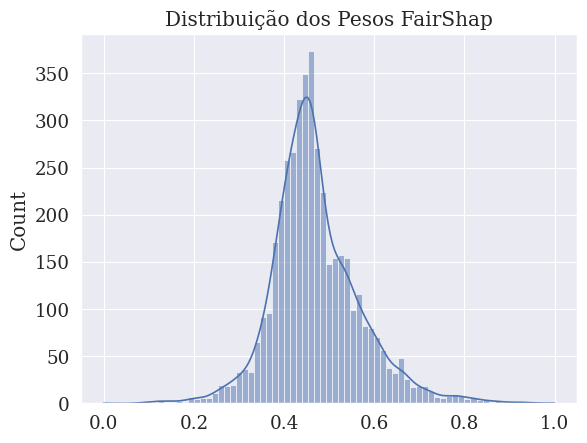

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
print(weights.mean())
sns.histplot(weights, kde=True)
plt.title("Distribuição dos Pesos FairShap")
plt.show()



C:\Users\Davi Araujo\AppData\Local\Temp\ipykernel_32648\134447158.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


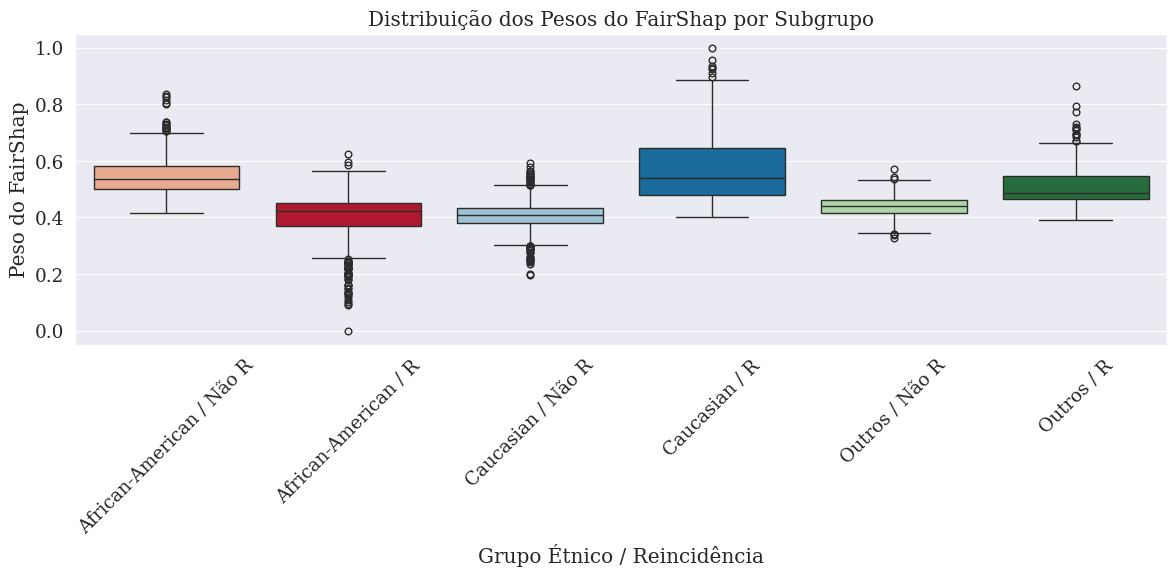

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Criar grupo racial
def determinar_grupo_raca(row):
    if row['African-American'] == 1:
        return 'African-American'
    elif row['Caucasian'] == 1:
        return 'Caucasian'
    else:
        return 'Outros'

X_train['Reincidencia'] = y_train
X_train['peso_fairshap'] = weights
X_train['grupo_raca'] = X_train.apply(determinar_grupo_raca, axis=1)
X_train['grupo_reinc'] = X_train['Reincidencia'].map({1: 'R', 0: 'Não R'})
X_train['subgrupo'] = X_train['grupo_raca'] + ' / ' + X_train['grupo_reinc']

# 🗂️ Definindo a ordem desejada dos subgrupos
ordem_subgrupos = [
    'African-American / Não R',
    'African-American / R',
    'Caucasian / Não R',
    'Caucasian / R',
    'Outros / Não R',
    'Outros / R'
]

# 🎨 Paleta de cores personalizada
cores_subgrupos = {
    'African-American / Não R': '#f4a582',  # vermelho claro
    'African-American / R':     '#ca0020',  # vermelho escuro
    'Caucasian / Não R':        '#92c5de',  # azul claro 
    'Caucasian / R':            '#0571b0',  # azul escuro 
    'Outros / Não R':           '#a6dba0',  # verde claro 
    'Outros / R':               '#1b7837'   # verde escuro 
}

# 📊 Gráfico com cores específicas
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='subgrupo',
    y='peso_fairshap',
    data=X_train,
    order=ordem_subgrupos,
    palette=cores_subgrupos
)
plt.title('Distribuição dos Pesos do FairShap por Subgrupo')
plt.xlabel('Grupo Étnico / Reincidência')
plt.ylabel('Peso do FairShap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Árvore de Decisão para Pesos do FairShap

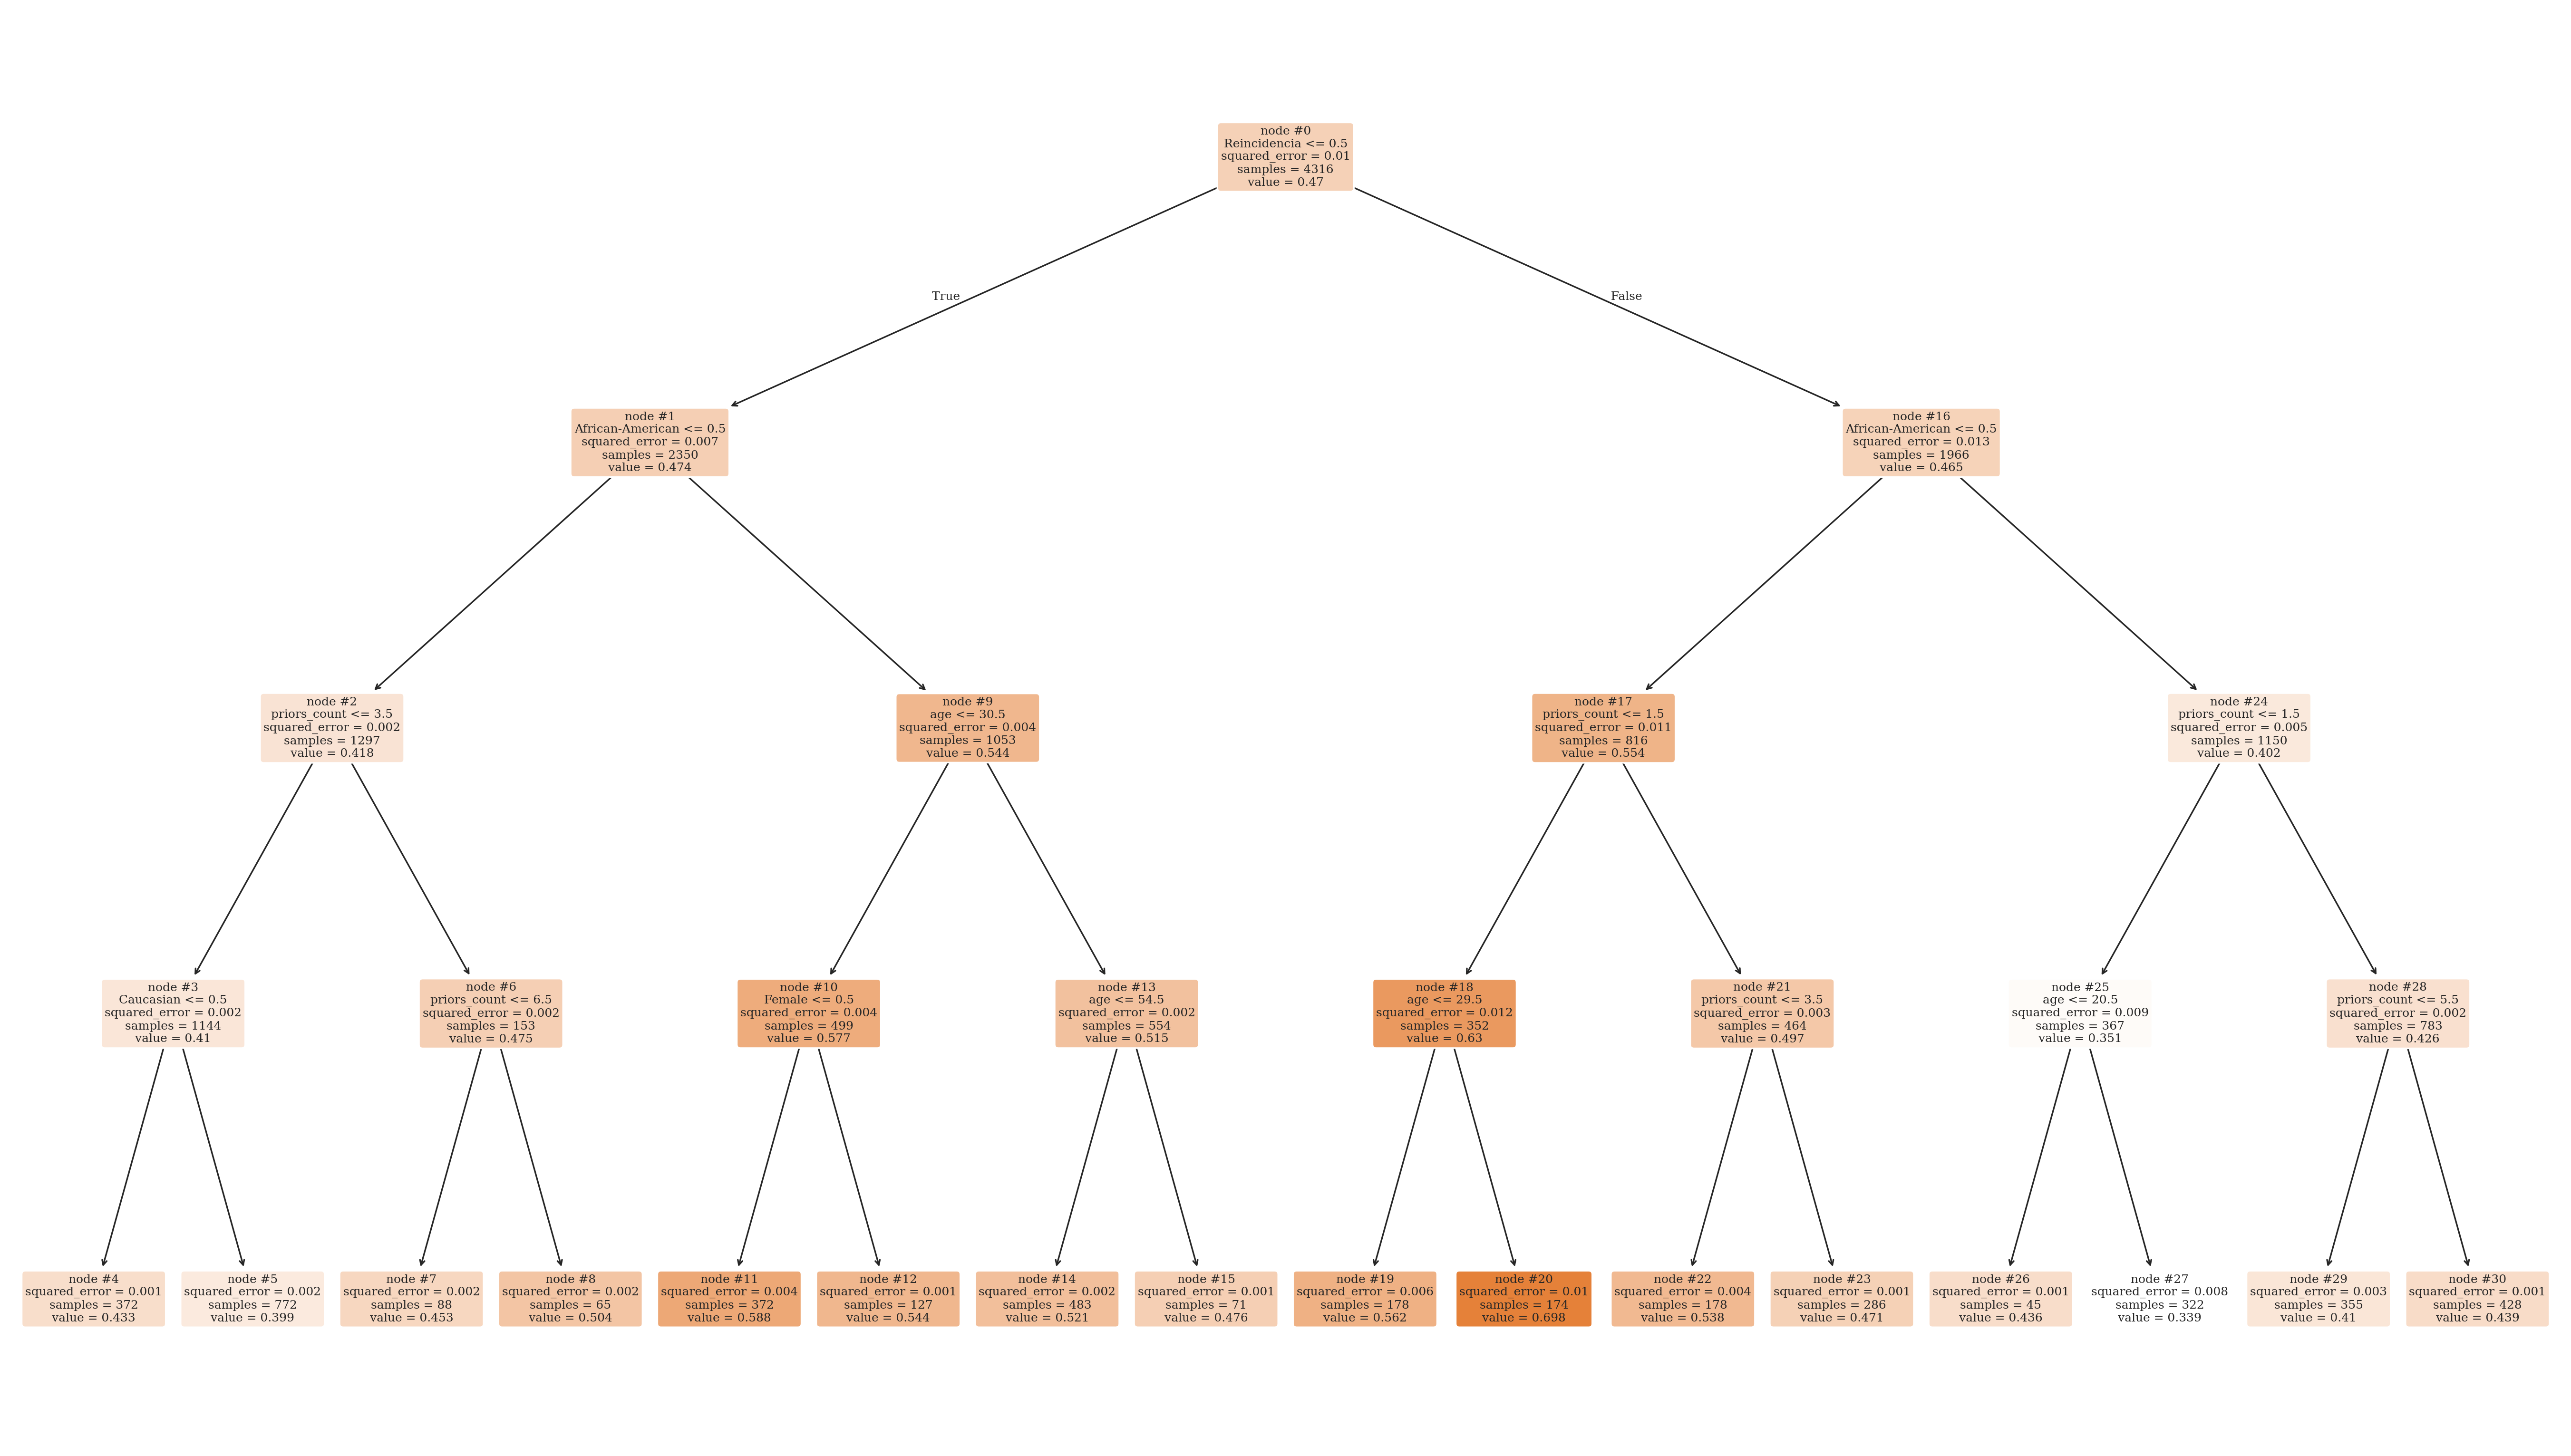

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

X = copia.copy()
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)


X_train['Reincidencia'] = y_train

# 🔧 Criar e treinar a árvore de regressão
reg_tree = DecisionTreeRegressor(
    max_depth=3,  # Controla profundidade
    min_samples_leaf=1,  # Evita splits muito pequenos
    random_state=42
)

# 🚀 Treinar a árvore usando os pesos como variável alvo
reg_tree.fit(X_train, weights)

# 🔍 Visualizar a árvore
plt.figure(figsize=(23, 13), dpi=300)
tree.plot_tree(
    reg_tree,
    filled=True,
    feature_names=X_train.columns,
    rounded=True,
    node_ids=True
)
plt.show()

### Gráfico de Barra das folhas

#### "Aware"

C:\Users\Davi Araujo\AppData\Local\Temp\ipykernel_32648\2153676620.py:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_raca = X_train.groupby('leaf_id').apply(obter_raca_dominante_e_perc).reset_index()


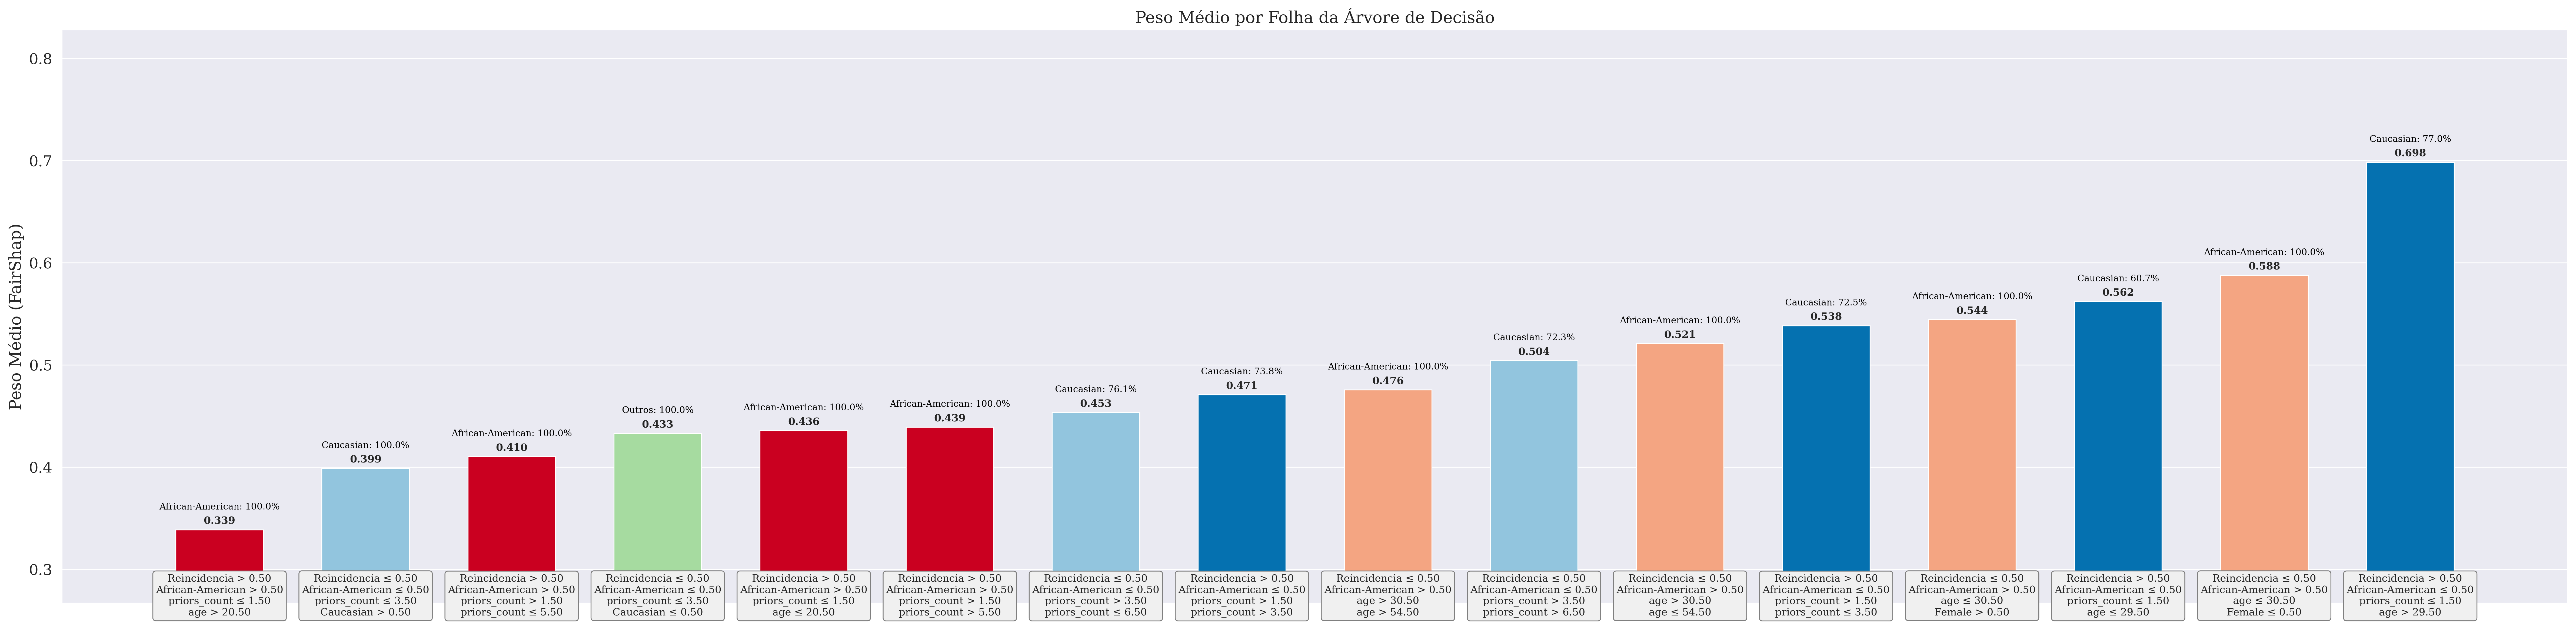

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import _tree

# 🔁 Paleta de cores por subgrupo (você já tinha isso)
cores_subgrupos = {
    'African-American / Não R': '#f4a582',  # vermelho claro
    'African-American / R':     '#ca0020',  # vermelho escuro
    'Caucasian / Não R':        '#92c5de',  # azul claro 
    'Caucasian / R':            '#0571b0',  # azul escuro 
    'Outros / Não R':           '#a6dba0',  # verde claro 
    'Outros / R':               '#1b7837'   # verde escuro 
}

# ─── 1) Monta X_train e atribui leaf_id ────────────────────────────────────────────────
X = copia.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train = X_train.copy()
X_train['Reincidencia'] = y_train
X_train['peso_fairshap'] = weights

# ─── 2) Define subgrupo (raça + reinc) ────────────────────────────────────────────────
def determinar_subgrupo(grupo):
    if grupo.get('African-American', 0) == 1:
        raca = 'African-American'
    elif grupo.get('Caucasian', 0) == 1:
        raca = 'Caucasian'
    else:
        raca = 'Outros'
    reinc = 'R' if grupo['Reincidencia'] == 1 else 'Não R'
    return f'{raca} / {reinc}'

X_train['subgrupo'] = X_train.apply(determinar_subgrupo, axis=1)

# ─── 3) Atribui leaf_id a cada linha ─────────────────────────────────────────────────
X_usado_na_arvore = X_train[reg_tree.feature_names_in_]
X_train['leaf_id'] = reg_tree.apply(X_usado_na_arvore)

# ─── 4) Agrega para calcular peso médio e tamanho da folha ───────────────────────────
folhas_df = X_train.groupby('leaf_id').agg({
    'peso_fairshap': 'mean',
    'leaf_id': 'size'
}).rename(columns={'leaf_id': 'n_amostras'}).reset_index()

# ─── 5) Extrai as regras (caminhos) da árvore, como antes ────────────────────────────
def extrair_regras_por_folha(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    caminhos = {}
    def recurse(node, caminho):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            nome = feature_name[node]
            threshold = tree_.threshold[node]
            left = tree_.children_left[node]
            right = tree_.children_right[node]
            recurse(left, caminho + [f"{nome} ≤ {threshold:.2f}"])
            recurse(right, caminho + [f"{nome} > {threshold:.2f}"])
        else:
            caminhos[node] = caminho
    recurse(0, [])
    return caminhos

regras_folhas = extrair_regras_por_folha(reg_tree, X_train.columns)
folhas_df['regras'] = folhas_df['leaf_id'].map(regras_folhas)

# ─── 6) Identifica, para cada folha, o subgrupo dominante (raça+reinc) e aplica cor ───
mapa_subgrupos = (
    X_train.groupby('leaf_id')['subgrupo']
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)
folhas_df['subgrupo'] = folhas_df['leaf_id'].map(mapa_subgrupos)
folhas_df['cor'] = folhas_df['subgrupo'].map(cores_subgrupos)

# ─── 7) (NOVO) Calcula a raça dominante e sua porcentagem em cada folha ───────────────
def obter_raca_dominante_e_perc(gr):
    """
    Recebe um sub-DataFrame X_train filtrado por leaf_id = i,
    calcula a contagem de African-American, Caucasian, Outros e retorna
    tupla (raca_dominante, porcentagem_dominante).
    """
    total = len(gr)
    # contagens diretas nos one-hot de raça
    cont_afam = int(gr['African-American'].sum())
    cont_cauc = int(gr['Caucasian'].sum())
    cont_outros = total - cont_afam - cont_cauc

    # monta dicionário para facilitar a busca do máximo:
    d = {'African-American': cont_afam, 'Caucasian': cont_cauc, 'Outros': cont_outros}
    raca_dom = max(d, key=d.get)                  # pega a chave com maior contagem
    perc = (d[raca_dom] / total) * 100.0           # porcentagem (0–100)
    return pd.Series({'raca_dominante': raca_dom, 'perc_raca_dominante': perc})

# Aplica groupby em X_train para extrair raça dominante e %, depois mapeia em folhas_df:
stats_raca = X_train.groupby('leaf_id').apply(obter_raca_dominante_e_perc).reset_index()
# Junta com folhas_df pelo leaf_id:
folhas_df = folhas_df.merge(stats_raca, on='leaf_id', how='left')

# ─── 8) (Já existente) Quebra regras em texto multi-linha para enxugar ─────────────────
import textwrap
def quebra_regras(regras, max_linhas=3, largura_quebra=30):
    texto = '\n'.join(regras)
    linhas_quebradas = []
    for linha in texto.split('\n'):
        linhas_quebradas.extend(textwrap.wrap(linha, largura_quebra))
    if len(linhas_quebradas) > max_linhas:
        linhas_quebradas = linhas_quebradas[:max_linhas]
        linhas_quebradas[-1] += '...'
    return '\n'.join(linhas_quebradas)

folhas_df['regras_str'] = folhas_df['regras'].apply(lambda r: quebra_regras(r, max_linhas=10, largura_quebra=30))

# ─── 9) Ordena pelas folhas de menor para maior peso médio ───────────────────────────────
folhas_df = folhas_df.sort_values(by='peso_fairshap', ascending=True).reset_index(drop=True)


# ─── 10) Plot final, exibindo também o percentual racial dominante ──────────────────────
altura_maxima = folhas_df['peso_fairshap'].max()
altura_minima = folhas_df['peso_fairshap'].min()
margem = (altura_maxima - altura_minima) * 0.2
n_folhas = len(folhas_df)
largura = max(10, n_folhas * 1.2)

plt.figure(figsize=(len(folhas_df) * 2, 8), dpi=300)

bars = plt.bar(
    range(n_folhas),
    folhas_df['peso_fairshap'],
    color=folhas_df['cor'],
    width=0.6
)

plt.title('Peso Médio por Folha da Árvore de Decisão')
plt.ylabel('Peso Médio (FairShap)')
plt.xticks([])

for i, (bar, regras_txt, valor, raca_dom, perc_dom) in enumerate(zip(
    bars,
    folhas_df['regras_str'],
    folhas_df['peso_fairshap'],
    folhas_df['raca_dominante'],
    folhas_df['perc_raca_dominante']
)):
    # 10.1) Desenha bloco com as regras (embaixo da barra)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura_minima - margem * 0.6,
        regras_txt,
        ha='center',
        va='top',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="#f0f0f0", edgecolor="gray")
    )
    # 10.2) Desenha valor do peso FairShap acima da barra
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + margem * 0.05,
        f"{valor:.3f}",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )
    # 10.3) (NOVO) Desenha a informação do percentual racial dominante,
    # colocada um pouco acima do valor do peso ou ao lado, conforme preferência.
    # Aqui colocamos logo acima do valor do peso, em tamanho um pouco menor:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + margem * 0.25,
        f"{raca_dom}: {perc_dom:.1f}%",   # ex.: "AfAm: 62.5%"
        ha='center',
        va='bottom',
        fontsize=8,
        color='black'
    )

plt.ylim(altura_minima - margem, altura_maxima + margem * 1.8)
plt.tight_layout()
plt.show()


#### "Unaware"

['Outros / Não R' 'Caucasian / Não R' 'Não Definido / Não R'
 'African-American / Não R' 'Não Definido / R' 'African-American / R']


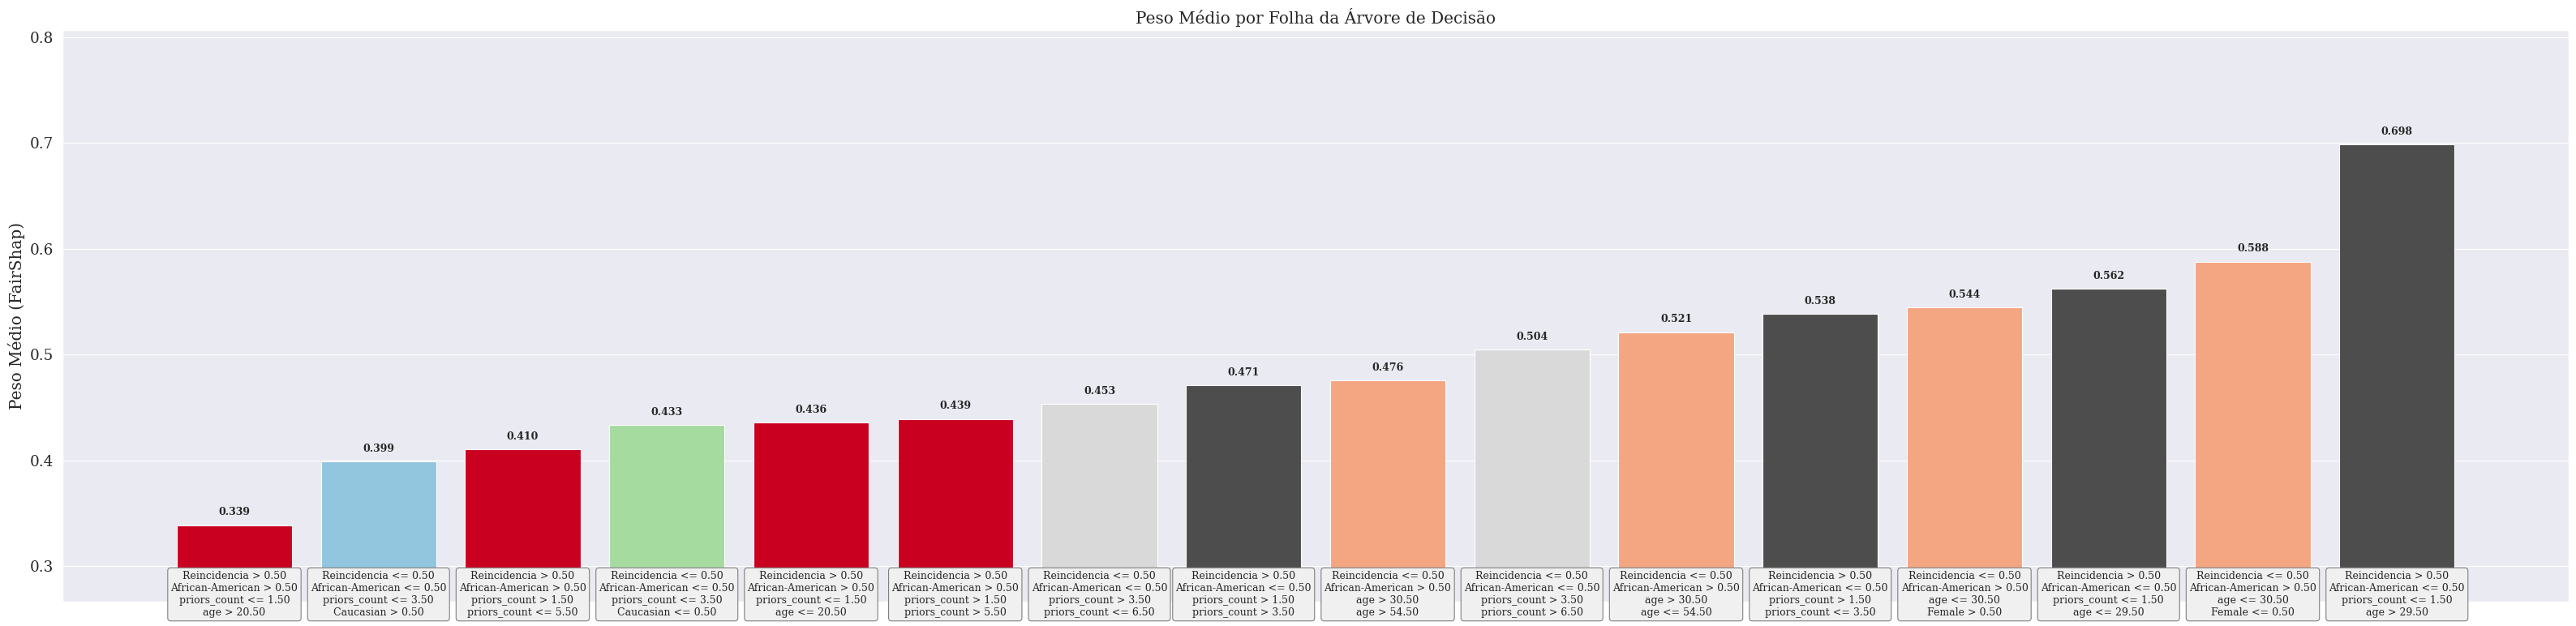

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import _tree

# 🎨 Paleta baseada apenas nas regras da árvore
cores_regras = {
    'African-American / R': '#ca0020',       # vermelho escuro
    'African-American / Não R': '#f4a582',   # vermelho claro
    'Caucasian / R': '#0571b0',              # azul escuro
    'Caucasian / Não R': '#92c5de',          # azul claro
    'Outros / R': '#1b7837',                 # verde escuro
    'Outros / Não R': '#a6dba0',             # verde claro
    'Não Definido / R': '#4d4d4d',           # preto
    'Não Definido / Não R': '#d9d9d9'        # preto
}

# 🔄 Dados
X = copia.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train['Reincidencia'] = y_train
X_train['peso_fairshap'] = weights

# 📌 Atribui folhas
X_usado_na_arvore = X_train[reg_tree.feature_names_in_]
X_train['leaf_id'] = reg_tree.apply(X_usado_na_arvore)

# 📊 Agrupa por folha
folhas_df = X_train.groupby('leaf_id').agg({
    'peso_fairshap': 'mean',
    'leaf_id': 'size'
}).rename(columns={'leaf_id': 'n_amostras'}).reset_index()

# 🔍 Extrai regras da árvore
def extrair_regras_por_folha(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    caminhos = {}
    def recurse(node, caminho):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            nome = feature_name[node]
            threshold = tree_.threshold[node]
            left = tree_.children_left[node]
            right = tree_.children_right[node]
            recurse(left, caminho + [f"{nome} <= {threshold:.2f}"])
            recurse(right, caminho + [f"{nome} > {threshold:.2f}"])
        else:
            caminhos[node] = caminho
    recurse(0, [])
    return caminhos

regras_folhas = extrair_regras_por_folha(reg_tree, X_train.columns)
folhas_df['regras'] = folhas_df['leaf_id'].map(regras_folhas)
folhas_df['regras_str'] = folhas_df['regras'].apply(lambda regras: '\n'.join(regras))

# 🧠 Detecta subgrupo com base nas REGRAS da árvore
def identificar_subgrupo_pela_regra(regras, X_train, leaf_id):
    texto = ' '.join(regras).lower()
    raca = 'Não Definido'

    if 'african-american <= 0.5' in texto and 'caucasian <= 0.5' in texto:
        raca = 'Outros'
    elif 'african-american >' in texto:
        raca = 'African-American'
    elif 'caucasian >' in texto:
        raca = 'Caucasian'

    grupo_folha = X_train[X_train['leaf_id'] == leaf_id]
    reinc_mais_freq = grupo_folha['Reincidencia'].mode()[0]
    reinc_txt = 'R' if reinc_mais_freq == 1 else 'Não R'

    return f'{raca} / {reinc_txt}'

# 📎 Aplica lógica para cada folha
folhas_df['subgrupo_regras'] = folhas_df.apply(
    lambda row: identificar_subgrupo_pela_regra(row['regras'], X_train, row['leaf_id']),
    axis=1
)
print(folhas_df['subgrupo_regras'].unique())

folhas_df['cor'] = folhas_df['subgrupo_regras'].map(cores_regras)

# 🔢 Ordena pelas folhas de menor para maior peso médio
folhas_df = folhas_df.sort_values(by='peso_fairshap', ascending=True).reset_index(drop=True)

# 📊 Gráfico
altura_maxima = folhas_df['peso_fairshap'].max()
altura_minima = folhas_df['peso_fairshap'].min()
margem = (altura_maxima - altura_minima) * 0.2
plt.figure(figsize=(len(folhas_df) * 2, 8))

bars = plt.bar(
    range(len(folhas_df)),
    folhas_df['peso_fairshap'],
    color=folhas_df['cor']
)

# 🧷 Adiciona bloquinhos com regras e valores
for i, (bar, texto, valor) in enumerate(zip(bars, folhas_df['regras_str'], folhas_df['peso_fairshap'])):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura_minima - margem * 0.6,
        texto,
        ha='center',
        va='top',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="#f0f0f0", edgecolor="gray")
    )
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + margem * 0.1,
        f"{valor:.3f}",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.ylim(altura_minima - margem, altura_maxima + margem * 1.5)
plt.ylabel('Peso Médio (FairShap)')
plt.title('Peso Médio por Folha da Árvore de Decisão')
plt.xticks([])
plt.tight_layout()
plt.show()


### Desempenho e Shapley Values

In [143]:
# 🔄 Dados
X = copia.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train['Reincidencia'] = y_train

%run func_aux.ipynb
desempenho_tradicional(reg_tree, X_train, weights, explain=False)

R2:  0.7118
MSE: 0.0028
MAE: 0.0380


(0.7117856418376214, 0.0028470338340837054, 0.03801561531039597)

🔍 Gerando explicabilidade global do modelo...


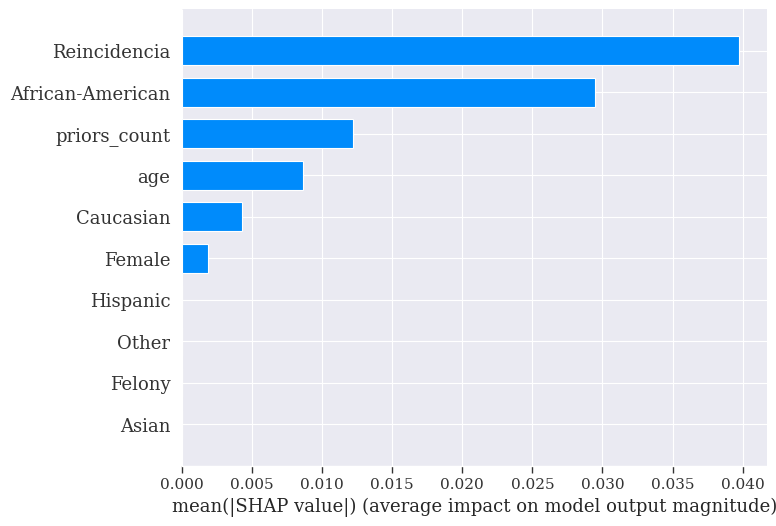

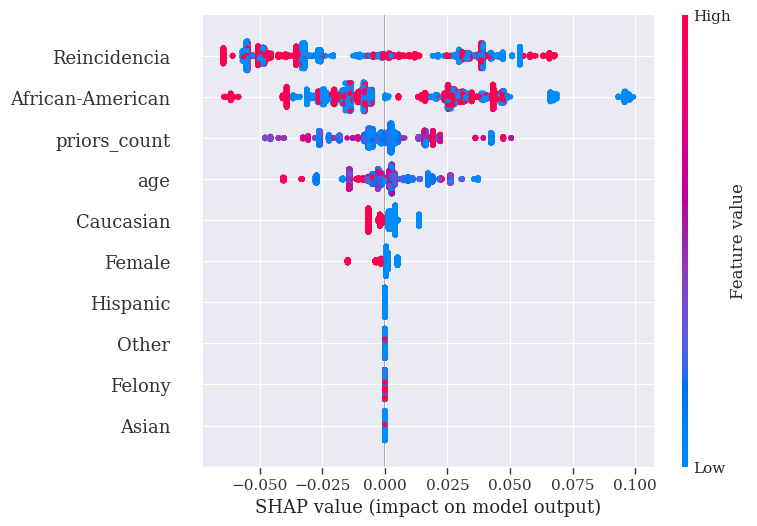

In [147]:
explain_model(reg_tree, X_train)

# Investigação da Efetividade do FairShap em Arvores

## FairShap - African American

In [158]:
X = copia.copy()
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)


weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='African-American',
    privileged_value=0,
    unprivileged_value=1,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1
)


# Calculating TSNE


Finding best k:   0%|          | 0/28 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Arvore Com FairShap

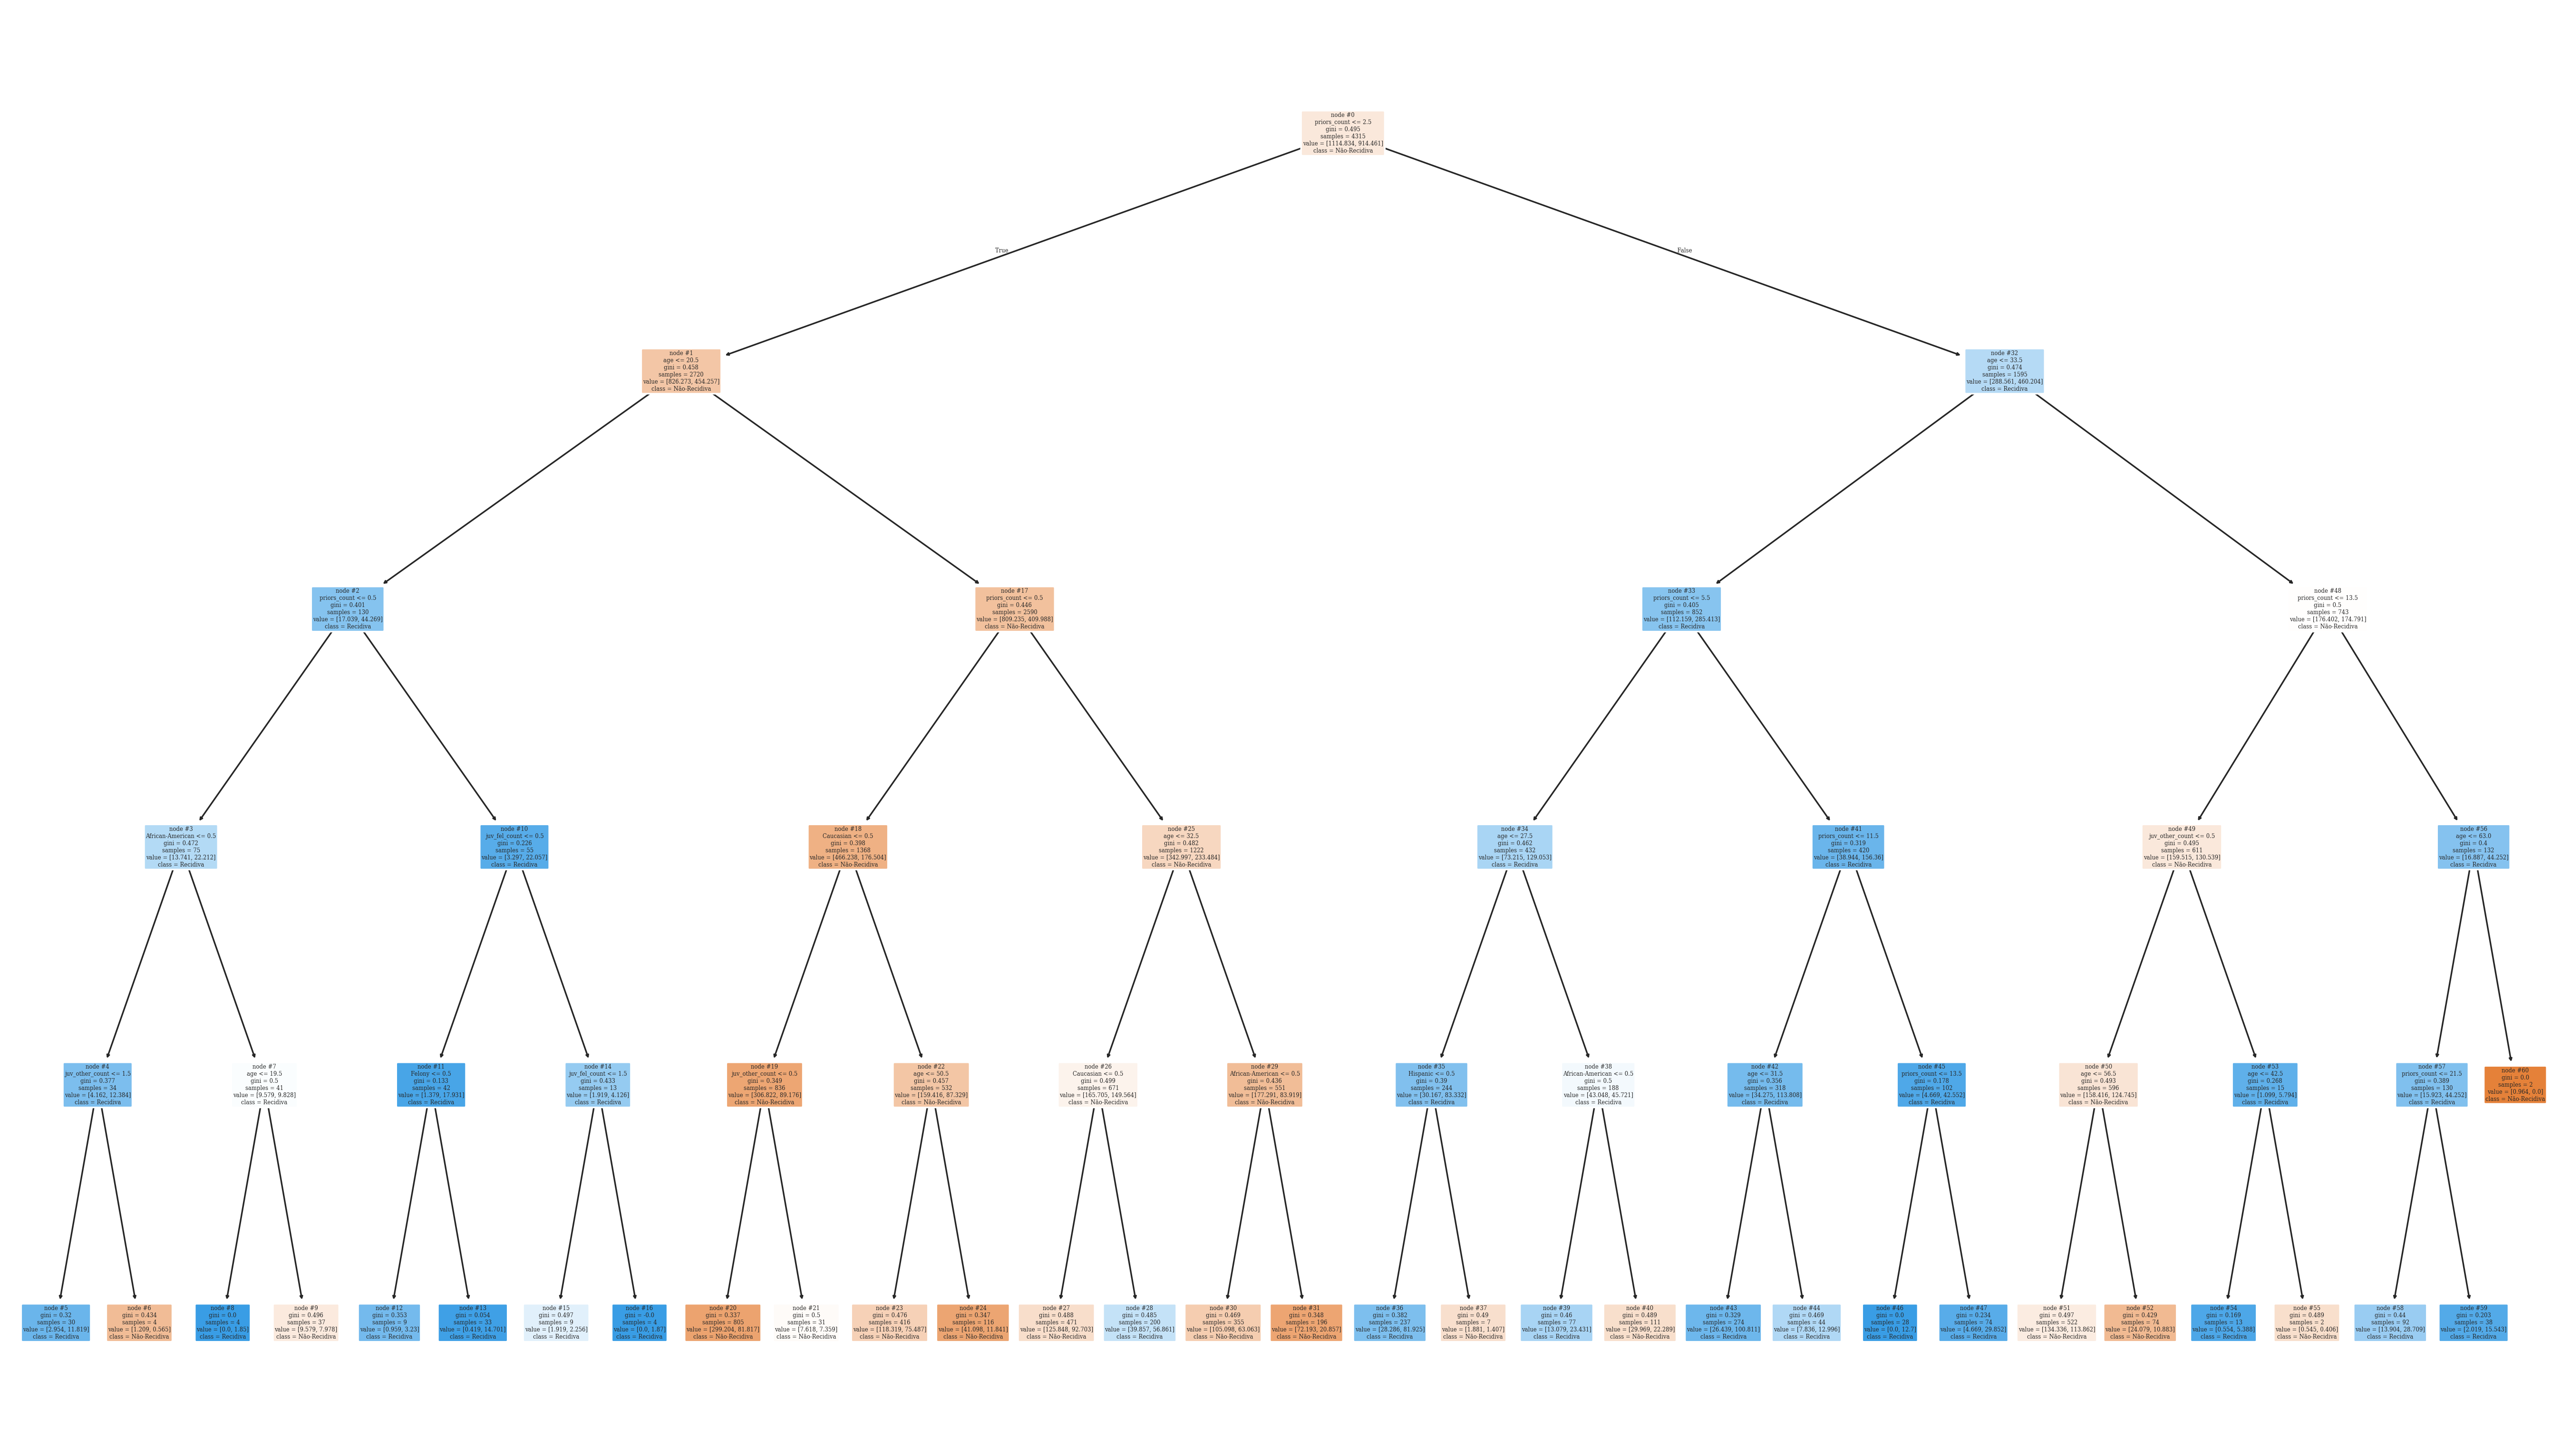

In [170]:
# 🔧 Criar e treinar a árvore de regressão
class_tree = DecisionTreeClassifier(
    max_depth=5,  # Controla profundidade
    min_samples_leaf=1,  # Evita splits muito pequenos
    random_state=42,
)

# 🚀 Treinar a árvore usando os pesos como variável alvo
class_tree.fit(X_train, y_train, sample_weight = weights)

# 🔍 Visualizar a árvore
plt.figure(figsize=(23, 13), dpi=300)

tree.plot_tree(
    class_tree,
    filled=True,
    feature_names=X_train.columns,
    rounded=True,
    node_ids=True,
    class_names=['Não-Recidiva', 'Recidiva']
)
plt.show()



### Desempenho

In [171]:
%run func_aux.ipynb
desempenho_tradicional(class_tree, X_test, y_test, explain=False)
y_pred = class_tree.predict(X_test)
eop = equal_opportunity(y_test, y_pred, X_test['African-American'], privileged_group=0)
print("\n🔍 Equal Opportunity (TPR): ",eop)
#Tem que adicionar Equal Opportunity



Acurácia:  0.6310
Precisão:  0.6626
Recall:    0.3867
F1-Score:  0.4884

🔍 Equal Opportunity (TPR):  0.07646829981373632


## Arvore Sem FairShap

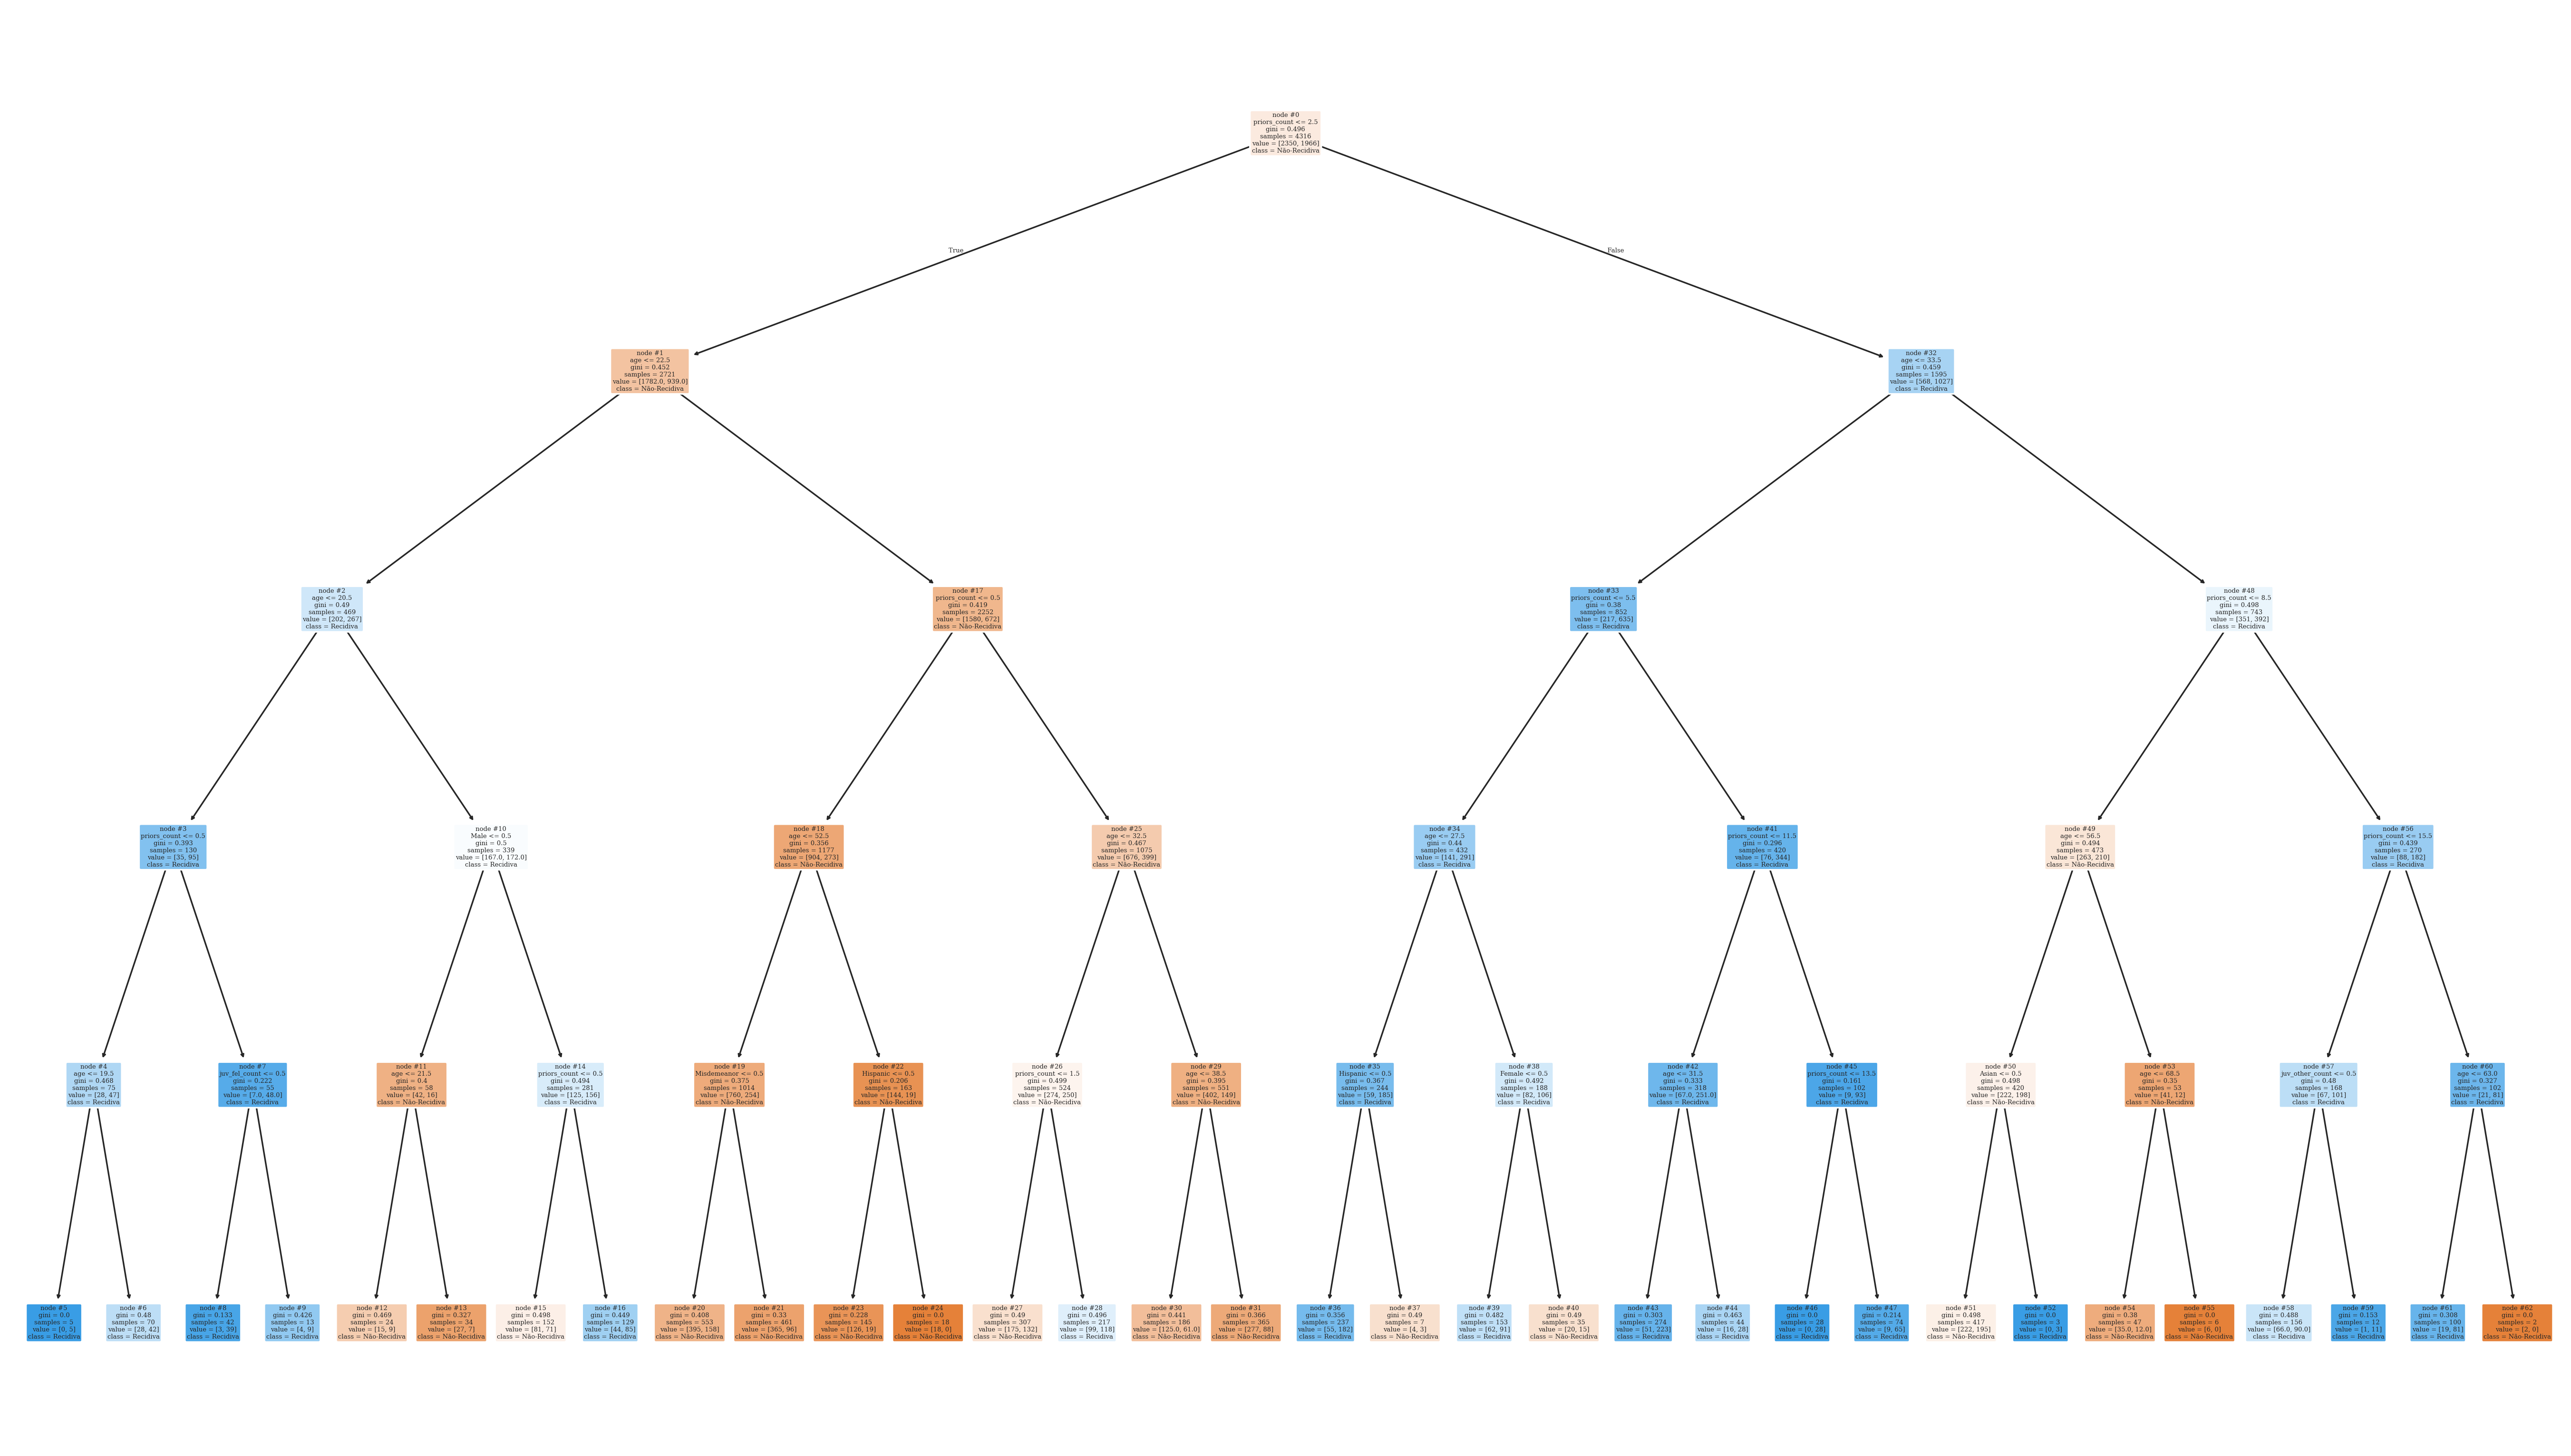

In [172]:
class_tree.fit(X_train, y_train)

# 🔍 Visualizar a árvore
plt.figure(figsize=(23, 13), dpi=300)
tree.plot_tree(
    class_tree,
    filled=True,
    feature_names=X_train.columns,
    rounded=True,
    node_ids=True,
    class_names=['Não-Recidiva', 'Recidiva']
)
plt.show()

### Desempenho

In [173]:
%run func_aux.ipynb
desempenho_tradicional(class_tree, X_test, y_test, explain=False)
y_pred = class_tree.predict(X_test)
eop = equal_opportunity(y_test, y_pred, X_test['African-American'], privileged_group=0)
print("\n🔍 Equal Opportunity (TPR): ",eop)
#Tem que adicionar Equal Opportunity



Acurácia:  0.6688
Precisão:  0.6737
Recall:    0.5291
F1-Score:  0.5927

🔍 Equal Opportunity (TPR):  0.2616120057529531


##  Hipótese 1: Aumentar a profundidade pode não mudar a acurácia, mas pode melhorar fairness

In [95]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.utils import resample

def equal_opportunity(y_true, y_pred, sensitive_attribute, privileged_group, positive_label=1):
    """Equal Opportunity = TPR(privileged) - TPR(unprivileged)"""
    def tpr(group):
        mask = (sensitive_attribute == group) & (y_true == positive_label)
        if mask.sum() == 0:
            return 0
        return recall_score(y_true[mask], y_pred[mask], zero_division=0)
    
    return abs(tpr(privileged_group) - tpr(1 - privileged_group))

def avaliar_arvores(X_train, y_train, X_test, y_test, sensitive_test, weights_fairshap, grupo_privilegiado):
    profundidades = range(3, 22)
    resultados = []

    for d in profundidades:
        for uso_peso, label_peso in zip([None, weights_fairshap], ["Sem Pesos", "Com FairShap"]):
            clf = DecisionTreeClassifier(max_depth=d, random_state=42)
            clf.fit(X_train, y_train, sample_weight=uso_peso)

            y_pred = clf.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            eop = equal_opportunity(y_test, y_pred, sensitive_test, grupo_privilegiado)

            resultados.append({
                "Profundidade": d,
                "Acurácia": acc,
                "Equal Opportunity": eop,
                "Peso": label_peso
            })

    return pd.DataFrame(resultados)


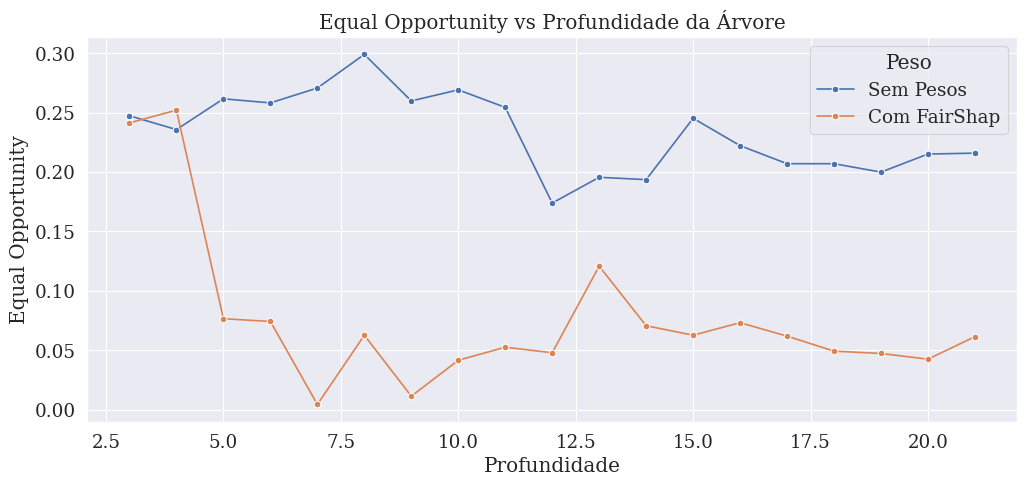

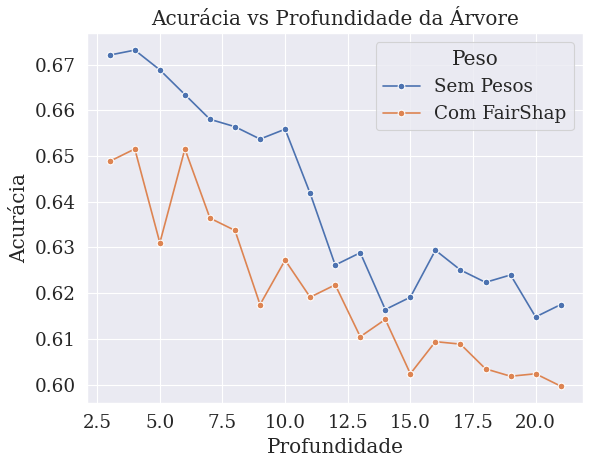

In [96]:
df_resultados = avaliar_arvores(X_train, y_train, X_test, y_test, sensitive_test=X_test['African-American'].values, 
                                weights_fairshap=weights, grupo_privilegiado=0)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_resultados, x="Profundidade", y="Equal Opportunity", hue="Peso", marker="o")
plt.title("Equal Opportunity vs Profundidade da Árvore")
plt.show()

sns.lineplot(data=df_resultados, x="Profundidade", y="Acurácia", hue="Peso", marker="o")
plt.title("Acurácia vs Profundidade da Árvore")
plt.show()


# Explicabilidade de Modelo

## Desempenho

In [ ]:
desempenho_tradicional(fairshap_african, X_test, y_test, explain=False)
desempenho_tradicional(baseline, X_test, y_test, explain=False)


##arrumar essa parte

y_pred = fairshap_african.predict(X_test)
eop = equal_opportunity(y_test, y_pred, X_test['African-American'], privileged_group=0)
print("\n🔍 Equal Opportunity (TPR) para o modelo FairShap African-American: ",eop)
y_pred = baseline.predict(X_test)
eop = equal_opportunity(y_test, y_pred, X_test['African-American'], privileged_group=0)
print("\n🔍 Equal Opportunity (TPR) para o modelo Baseline African-American: ",eop)

## Explain Model

🔍 Gerando explicabilidade global do modelo...


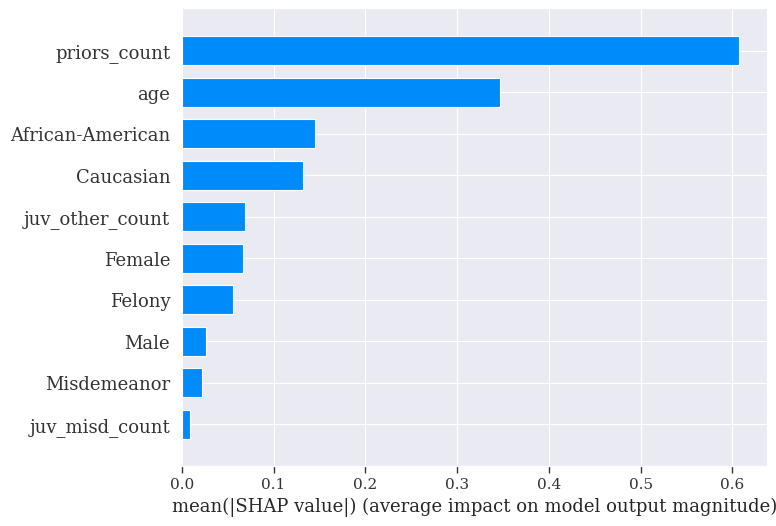

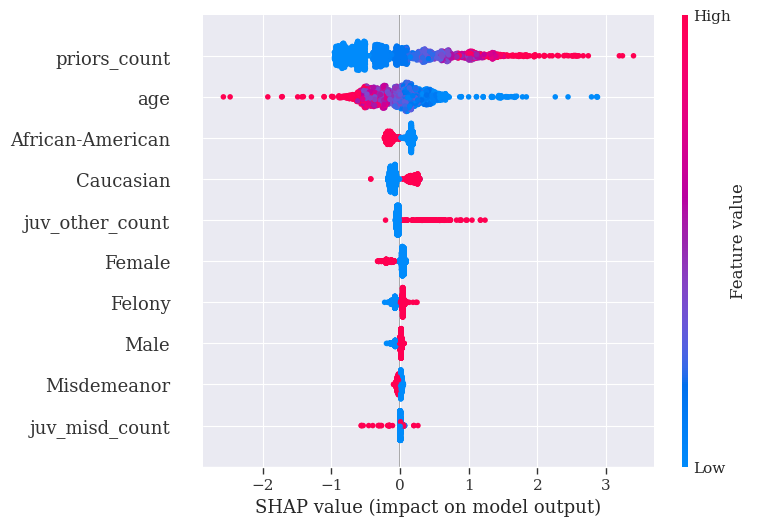

🔍 Gerando explicabilidade global do modelo...


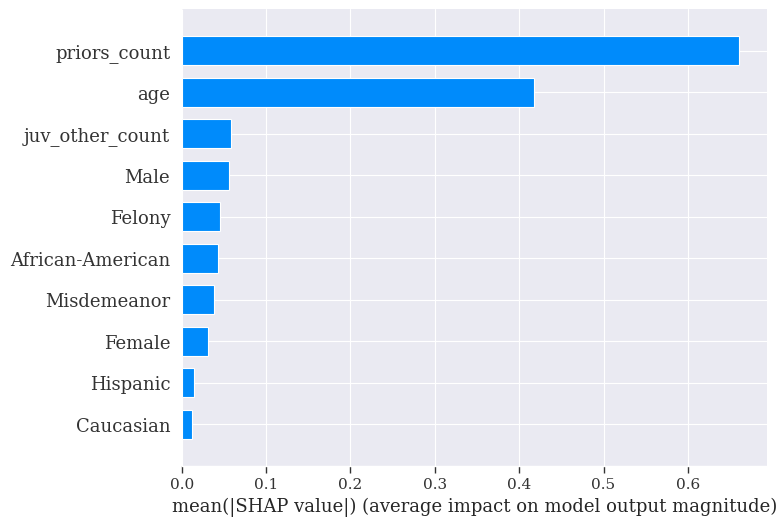

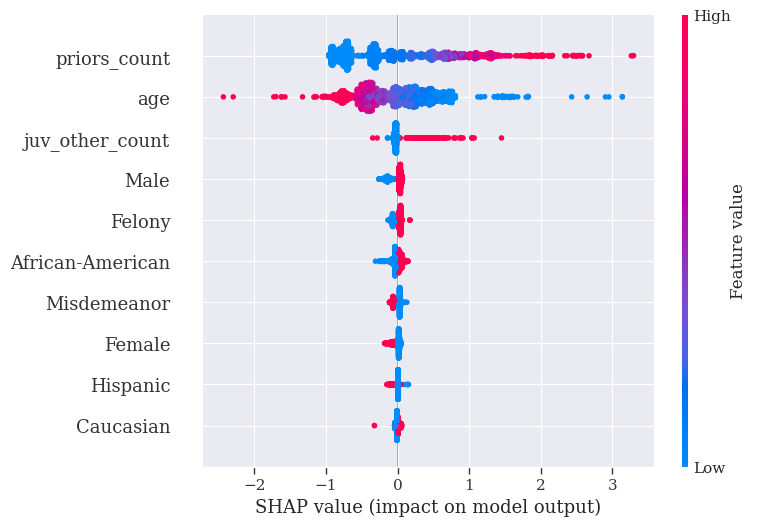

In [ ]:
explain_model(fairshap_african, X_test)
explain_model(baseline, X_test)

## Explain Individual


🔍 Explicabilidade local para a instância 0:


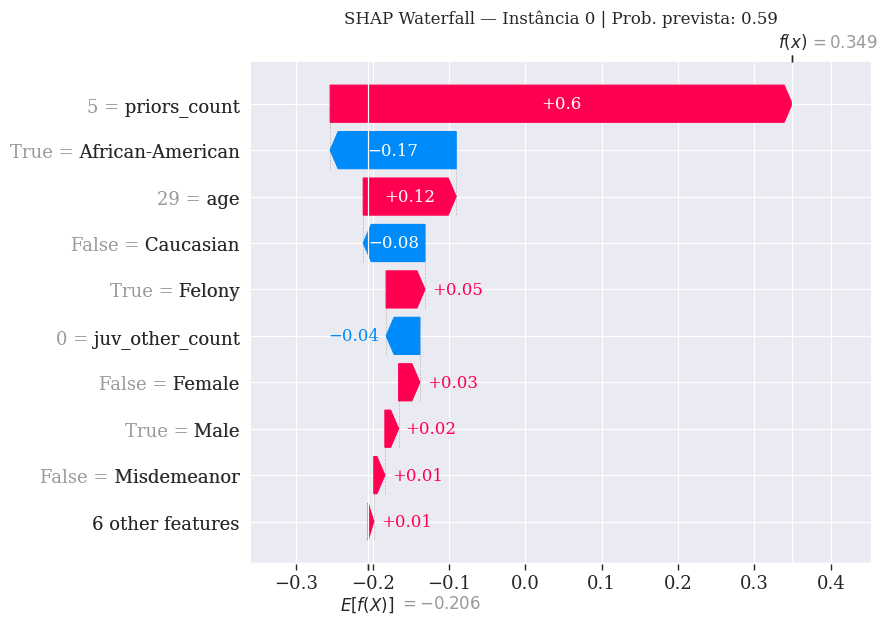


🔍 Explicabilidade local para a instância 1:


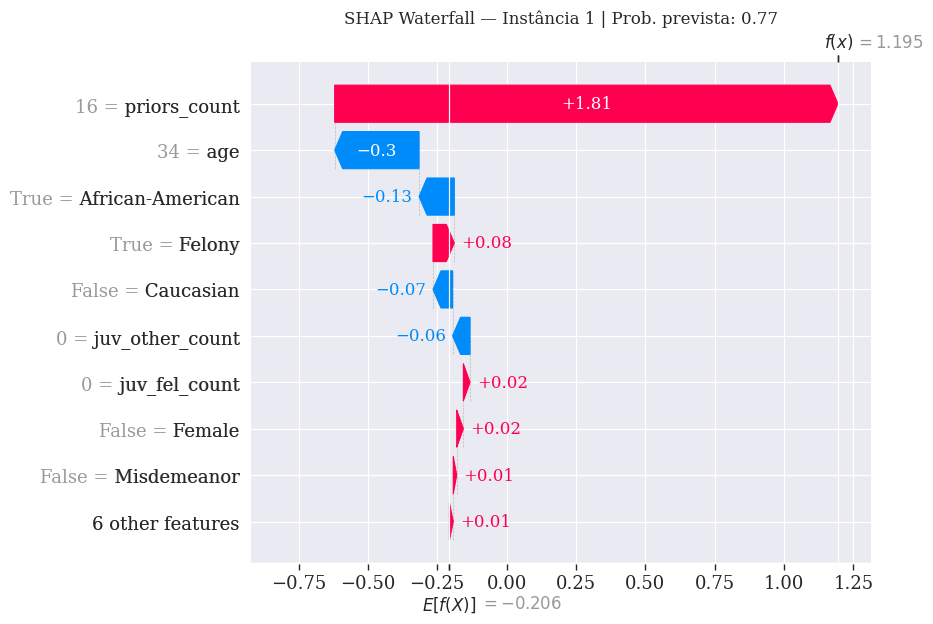

In [97]:
for index in range(2):
    print(f"\n🔍 Explicabilidade local para a instância {index}:")
    explain_individual(index=index, model=fairshap_african, X_train=X_train)